In [1]:
import torch
from torch import nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
num_workers = 2
batch_size = 64
valid_size = 0.1
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True,download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,download=True, transform=transform)
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


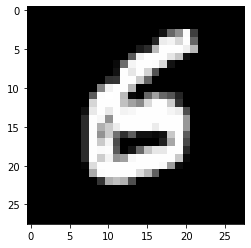

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
plt.imshow(images[1].squeeze(), cmap='Greys_r');

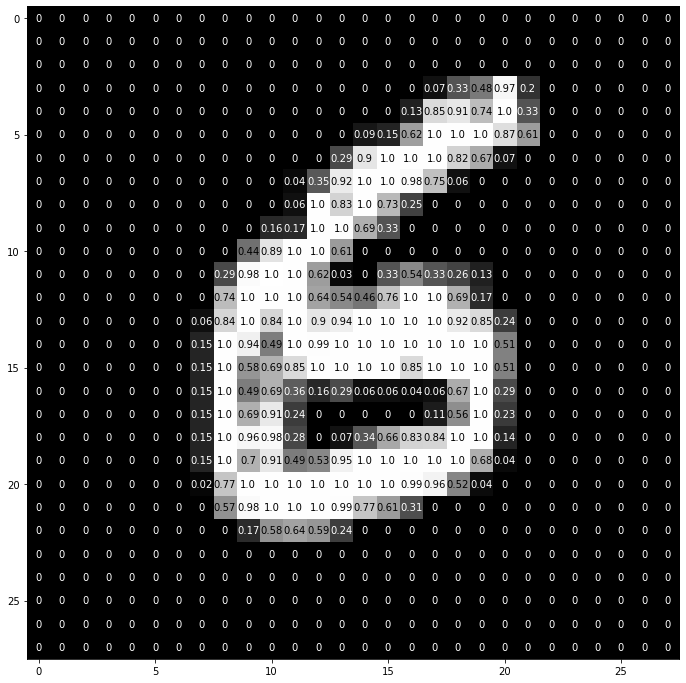

In [5]:
img = np.squeeze(images[1])
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [6]:
if torch.cuda.is_available():
    print('CUDA is available!  Training on GPU ...')
    device=torch.device('cuda')
else:
    print('CUDA is not available.  Training on CPU ...')
    device=torch.device('cpu')

CUDA is available!  Training on GPU ...


In [7]:
input_size = 784
hidden_sizes = [256,128, 64]
output_size = 10
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Dropout(p=0.5),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Dropout(p=0.5),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Dropout(p=0.5),
                      nn.Linear(hidden_sizes[2], output_size),
                      nn.LogSoftmax(dim=1))

moel=model.to(device)
print(model)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
criterion=nn.NLLLoss()

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
  (10): LogSoftmax(dim=1)
)


In [8]:
from torchsummary import summary
summary = summary(model)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            200,960
├─ReLU: 1-2                              --
├─Dropout: 1-3                           --
├─Linear: 1-4                            32,896
├─ReLU: 1-5                              --
├─Dropout: 1-6                           --
├─Linear: 1-7                            8,256
├─ReLU: 1-8                              --
├─Dropout: 1-9                           --
├─Linear: 1-10                           650
├─LogSoftmax: 1-11                       --
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0


In [9]:
from tqdm.notebook import tqdm
n_epochs = 100

valid_loss_min = np.Inf 
last_loss=None
train_losses, val_losses, train_accuracy ,val_accuracy =[] ,[], [], []
for epoch in tqdm(range(1, n_epochs+1)):
    train_class_correct = list(0. for i in range(10))
    train_class_total = list(0. for i in range(10))
    val_class_correct = list(0. for i in range(10))
    val_class_total = list(0. for i in range(10))
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for i,(image, target) in enumerate(train_loader):
        image, target = image.to(device), target.to(device)
        image=image.view(image.shape[0],-1)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*image.size(0)
        
        _, train_pred = torch.max(output, 1)
        train_correct = np.squeeze(train_pred.eq(target.data.view_as(train_pred)))
        for i in range(len(target)):
            label = target.data[i].item()
            train_class_correct[label] += train_correct[i].item()
            train_class_total[label] += 1
    train_accuracy.append(np.sum(train_class_correct) / np.sum(train_class_total))
    model.eval()
    for image, target in valid_loader:
        image, target = image.to(device), target.to(device)
        image=image.view(image.shape[0],-1)
        output = model(image)
        loss = criterion(output, target)
        valid_loss += loss.item()*image.size(0)
        _, val_pred = torch.max(output, 1)
        val_correct = np.squeeze(val_pred.eq(target.data.view_as(val_pred)))
        for i in range(len(target)):
            label = target.data[i].item()
            val_class_correct[label] += val_correct[i].item()
            val_class_total[label] += 1
    val_accuracy.append(np.sum(val_class_correct) / np.sum(val_class_total))
        
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'minst_model.pt')
        valid_loss_min = valid_loss

  0%|          | 0/100 [00:00<?, ?it/s]

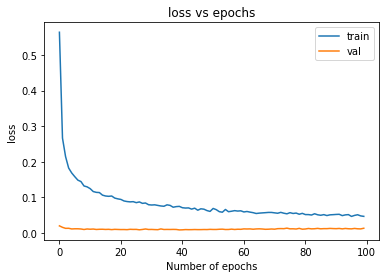

In [10]:
plt.title("loss vs epochs")
plt.xlabel('Number of epochs')
plt.ylabel('loss')
plt.plot(train_losses,label='train')
plt.plot(val_losses,label='val')
plt.legend()
plt.show()

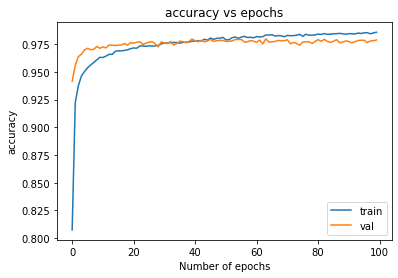

In [11]:
plt.title("accuracy vs epochs")
plt.xlabel('Number of epochs')
plt.ylabel('accuracy')
plt.plot(train_accuracy,label='train')
plt.plot(val_accuracy,label='val')
plt.legend()
plt.show()

In [12]:
model.load_state_dict(torch.load('minst_model.pt'))

<All keys matched successfully>

In [13]:
def view_classify(img, ps):
    ps = ps.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


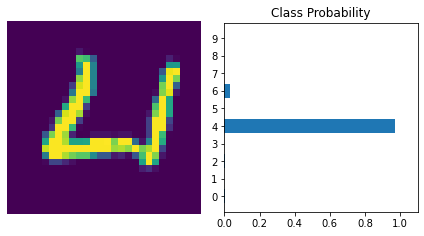

In [14]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[np.random.randint(len(images))].view(1, 784)
model=model.to(torch.device('cpu'))
with torch.no_grad():
    logps = model(img)
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)
plt.show()

In [18]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model=model.to(device)
classes=list(range(10))
model.eval()

for image, target in test_loader:
    image, target = image.to(device), target.to(device)
    image=image.view(image.shape[0],-1)
    output = model(image)
    loss = criterion(output, target)
    test_loss += loss.item()*image.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i].item()
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.5f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.08635

Test Accuracy of 0: 99% (972/980)
Test Accuracy of 1: 98% (1122/1135)
Test Accuracy of 2: 98% (1016/1032)
Test Accuracy of 3: 98% (992/1010)
Test Accuracy of 4: 97% (960/982)
Test Accuracy of 5: 98% (877/892)
Test Accuracy of 6: 98% (940/958)
Test Accuracy of 7: 97% (1002/1028)
Test Accuracy of 8: 97% (949/974)
Test Accuracy of 9: 96% (971/1009)

Test Accuracy (Overall): 98% (9801/10000)


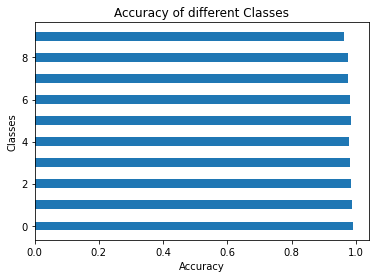

In [19]:
class_accuracy=list(0 for i in range(10))
for i in range(10):
    class_accuracy[i]=class_correct[i]/class_total[i]
plt.barh(classes, class_accuracy,height = 0.4)
 
plt.ylabel("Classes")
plt.xlabel("Accuracy")
plt.title("Accuracy of different Classes")
plt.show()